# Single cell fluorescence/holographic trajectory plotting

Designed to measure a series of time-dependent single cell fluorescent/holographic intensities and then plot them on comparative graphs


```
Author: 
- Nathan J. Day (nathan.day.16@ucl.ac.uk)
```


### STEPS
1. Measure the intenstities of the cell trajectories and save out as csv and pandas dataframe
2. Plot these trajectories 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import ndimage
from skimage import io
from sklearn import preprocessing

## Measure 

Read single cell mask information and obtain fluorescent and phase stats. If the data already exists in a .csv and just needs to be plotted then skip to the plotter section.

#### Raw data (image) location

The image data needs to be organised inside the ```root_dir``` as follows:

```
phase/
    0000_phase.tif
    0001_phase.tif
    ...
gfp/
    0000_gfp.tif
    0001_gfp.tif
    ...
rfp/
    0000_rfp.tif
    0001_rfp.tif
    ...
```
And the corresponding mask data needs to be organised inside the ```mask_version``` folder in the ```root_dir``` as follows:

```
singlecell_labels_manual/labels_cell1a
                            0000_mask.tif
                            0001_mask.tif
                            ...
singlecell_labels_manual/labels_cell2a
                            0000_mask.tif
                            0001_mask.tif
                            ...
singlecell_labels_manual/labels_cell...
```
where the ```singlecell_labels_manual = mask_version``` at the time of writing

In [2]:
root_path = "C:/Users/Nathan/Documents/data/fucci/"

gfp_dir = os.path.join(root_path, "gfp")
rfp_dir = os.path.join(root_path, "rfp")
phase_dir = os.path.join(root_path, "phase")

gfp_list = [m for m in os.listdir(gfp_dir) if m.endswith('.tif')]
rfp_list = [m for m in os.listdir(rfp_dir) if m.endswith('.tif')]
phase_list = [m for m in os.listdir(phase_dir) if m.endswith('.tif')]

cell_ids = ["1a", "1b", "2a", "2b", "3a", "3b", "4", "5"]
mask_type = "gold" #gold standard or modelv4, modelv5 etc
 

In [3]:
for cell in cell_ids:

    masks_dir_name = "labels_cell" + cell 
    masks_dir = os.path.normpath(os.path.join(root_path, "singlecell_labels_manual", masks_dir_name))
    mask_list = [m for m in os.listdir(masks_dir) if m.endswith('modified.tif')] # add something to include unmodified if modified doesnt exist?

    ### DIRECTORY CREATION ###
    stats_dir = os.path.join(root_path, 'stats') 
    try:
    # Create target Directory
        os.mkdir(stats_dir)
        print("Directory " , stats_dir ,  " Created ") 
    except FileExistsError:
        print("Directory " , stats_dir ,  " already exists")
    
    mask_type_stats_dir = os.path.join(stats_dir, mask_type) 
    try:
    # Create target Directory
        os.mkdir(mask_type_stats_dir)
        print("Directory " , mask_type_stats_dir ,  " Created ") 
    except FileExistsError:
        print("Directory " , mask_type_stats_dir ,  " already exists")    
            
    stat_file_dir = os.path.normpath(os.path.join(mask_type_stats_dir, "cell"+cell))
    try:
    # Create target Directory
        os.mkdir(stat_file_dir)
        print("Directory " , stat_file_dir ,  " Created ") 
    except FileExistsError:
        print("Directory " , stat_file_dir ,  " already exists")        
        #create target file
    stat_file = os.path.normpath(os.path.join(stat_file_dir, 'stats.csv'))
    
    df = pd.DataFrame([], columns=['GFP Intensity', 'RFP Intensity', 'Phase Intensity', 'Area', 'x','y']) #is this assignment of df correct? or does it overwrite "count_cells" above
   
    for i, mask_name in enumerate(mask_list):
        #useful for troubleshooting
        #print(i)
        #print(cell) 
        
        mask = io.imread(os.path.normpath(os.path.join(masks_dir, mask_name)))
        labelled, n_labels = ndimage.label(mask)
        
        gfp = io.imread(os.path.join(gfp_dir,gfp_list[i]))
        gfp_pix_value = ndimage.sum(gfp, labelled, 1) 
    
        rfp = io.imread(os.path.join(rfp_dir,rfp_list[i]))
        rfp_pix_value = ndimage.sum(rfp, labelled, 1)
        
        phase = io.imread(os.path.join(phase_dir,phase_list[i]))
        phase_pix_value = ndimage.sum(phase, labelled, 1)

        
        df.loc[i,'GFP Intensity'] = gfp_pix_value 
        df.loc[i,'RFP Intensity'] = rfp_pix_value
        df.loc[i,'Phase Intensity'] = phase_pix_value 
        df.loc[i,'Area'] = ndimage.sum(mask)
        #df.loc[i,'Max'] =  ndimage.maximum(phase, labelled)

        centroid = ndimage.measurements.center_of_mass(mask)
        y = centroid[0]
        x = centroid[1]
        df.loc[i,'x'] = format(x, '.2f')
        df.loc[i,'y'] = format(y, '.2f')
    
    df.to_csv(stat_file, index=False)  
    print(df)
print('FIN')    

Directory  C:/Users/Nathan/Documents/data/fucci/stats  already exists
Directory  C:/Users/Nathan/Documents/data/fucci/stats\gold  already exists
Directory  C:\Users\Nathan\Documents\data\fucci\stats\gold\cell1a  already exists
0
1a
1
1a
2
1a
3
1a
4
1a
5
1a
6
1a
7
1a
8
1a
9
1a
10
1a
11
1a
12
1a
13
1a
14
1a
15
1a
16
1a
17
1a
18
1a
19
1a
20
1a
21
1a
22
1a
23
1a
24
1a
25
1a
26
1a
27
1a
28
1a
29
1a
30
1a
31
1a
32
1a
33
1a
34
1a
35
1a
36
1a
37
1a
38
1a
39
1a
40
1a
41
1a
42
1a
43
1a
44
1a
45
1a
46
1a
47
1a
48
1a
49
1a
50
1a
51
1a
52
1a
53
1a
54
1a
55
1a
56
1a
57
1a
58
1a
59
1a
60
1a
61
1a
62
1a
63
1a
64
1a
65
1a
66
1a
67
1a
68
1a
69
1a
70
1a
71
1a
72
1a
73
1a
74
1a
75
1a
76
1a
77
1a
78
1a
79
1a
80
1a
81
1a
82
1a
83
1a
84
1a
85
1a
86
1a
87
1a
88
1a
89
1a
90
1a
91
1a
92
1a
93
1a
94
1a
95
1a
96
1a
97
1a
98
1a
99
1a
100
1a
101
1a
102
1a
103
1a
104
1a
105
1a
106
1a
107
1a
108
1a
109
1a
110
1a
111
1a
112
1a
113
1a
114
1a
115
1a
116
1a
117
1a
118
1a
119
1a
120
1a
121
1a
122
1a
123
1a
124
1a
125
1a
1

KeyboardInterrupt: 

### Load data
If the data already exists in a .csv and just needs to be plotted then skip to this part, **but make sure you uncomment then following cell!**

+ Number of cells
+ Number of frames/timepoints (length of trajectory)

##### At time of writing this the data organisation is as follows
Stats.csv:

|   |GFP Intensity|RFP Intensity|Phase Intensity|Area| x | y |
|---|-------------|-------------|---------------|----|---|---|
|1  |             |             |               |    |   |   |
|2  |             |             |               |    |   |   |
|...|             |             |               |    |   |   |
|t  |             |             |               |    |   |   |

And the directory organisation is as follows:

```
root_path/stats/mask_version/
                          cell1/stats.csv
                          cell2/stats.csv
                          ...
```
Where ```mask_version``` could be any of the following
```
mask_version = { /gold
                 /modelv4
                 /modelv5
                     ... } 
```

In [4]:
### Data location ###
root_path = "C:/Users/Nathan/Documents/data/fucci/stats/gold"
cell_ids = ["1a", "1b", "2a", "2b", "3a", "3b", "4", "5"]

In [14]:
def colour_picker(variable_title):
        colour_list = ["GFP", "RFP", "Phase"]
        for colour in colour_list:
            if colour in variable_title:
                if colour == "GFP": 
                    return 'green'
                elif colour == 'RFP':
                    return 'red'
                elif colour == 'Phase':
                    return 'yellow'
                else:
                    return "Could not find a suitable colour to plot in, check colour_picker function"

def normalisation(series):
    max_series = np.amax(series)
    norm_factor = 1 / max_series
    scaled_series = series * norm_factor
    return scaled_series

### not sure im using this type of class correctly, but this maps cell_id to normalised_stats path location
class cell_id_stat_location:
    def __init__(self, cell_id, path):
        self.cell_id = cell_id
        self.path = path
        print("Initialised")
cell_info = [cell_id_stat_location("1a", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell1a\\normalised_stats.csv'), cell_id_stat_location("1b", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell1b\\normalised_stats.csv'), cell_id_stat_location("2a", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell2a\\normalised_stats.csv'), cell_id_stat_location("2b", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell2b\\normalised_stats.csv'), cell_id_stat_location("3a", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell3a\\normalised_stats.csv'), cell_id_stat_location("3b", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell3b\\normalised_stats.csv'), cell_id_stat_location("4", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell4\\normalised_stats.csv'), cell_id_stat_location("5", 'C:/Users/Nathan/Documents/data/fucci/stats/gold\\cell5\\normalised_stats.csv')] 

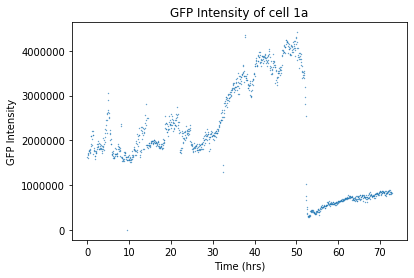

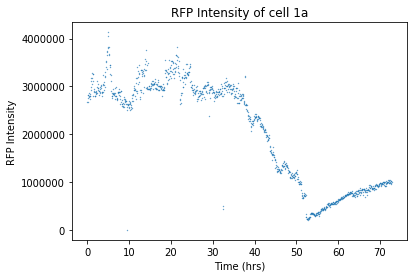

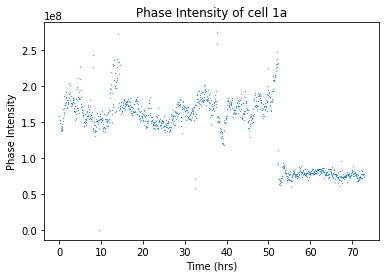

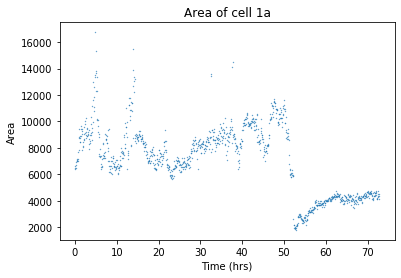

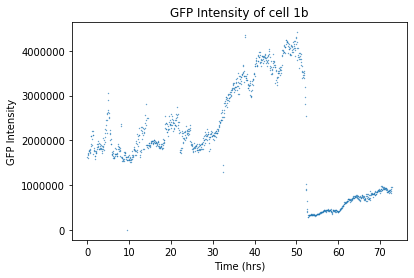

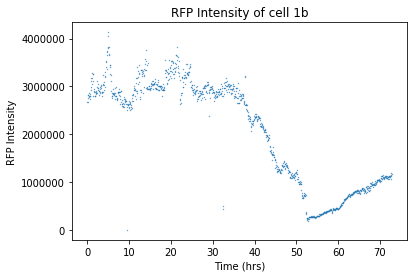

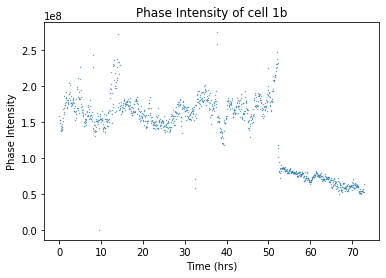

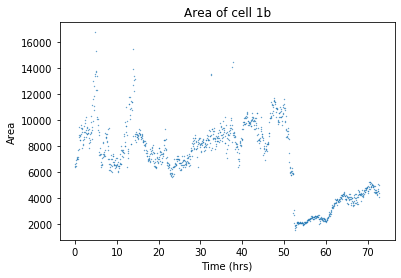

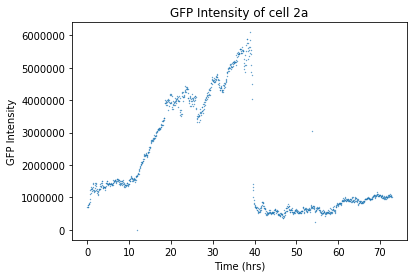

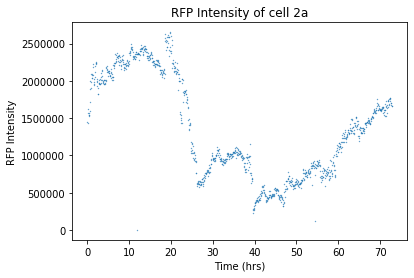

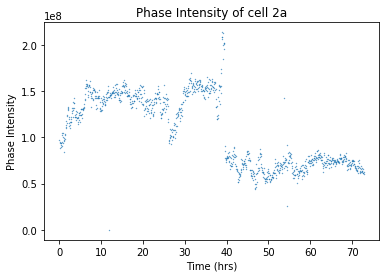

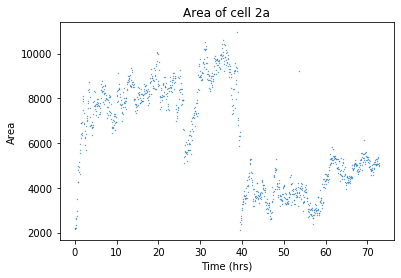

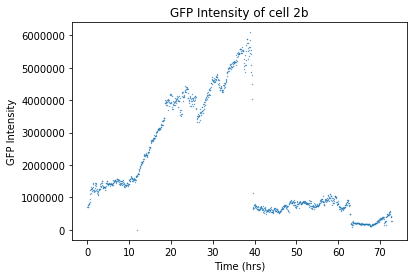

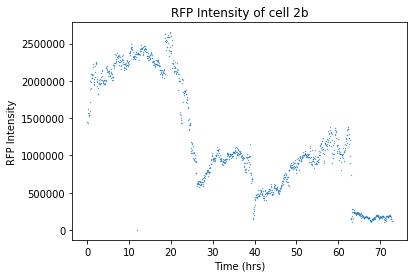

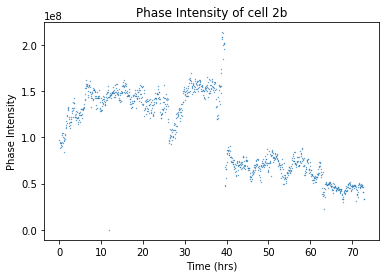

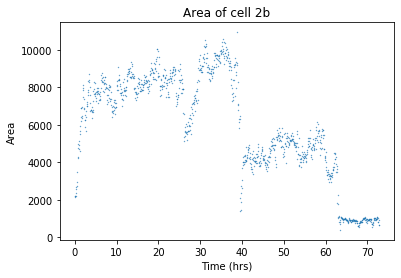

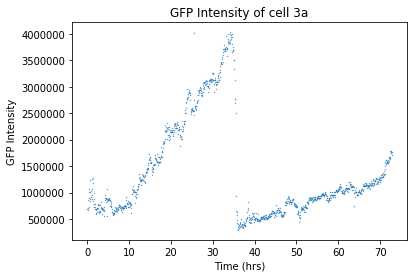

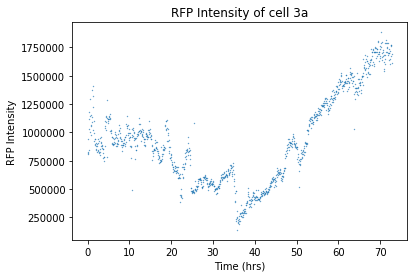

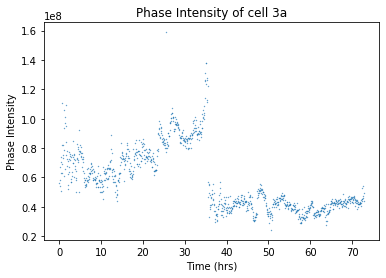

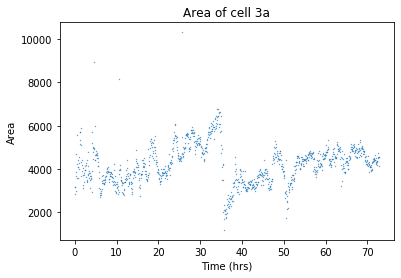

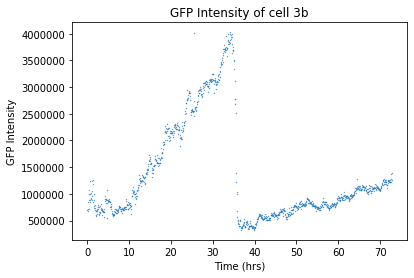

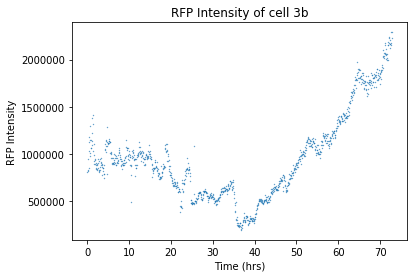

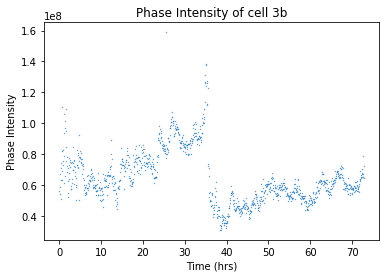

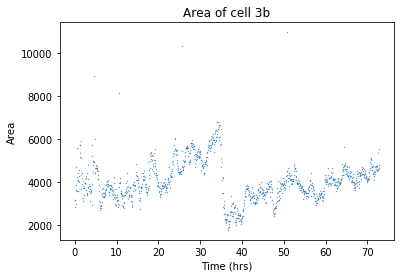

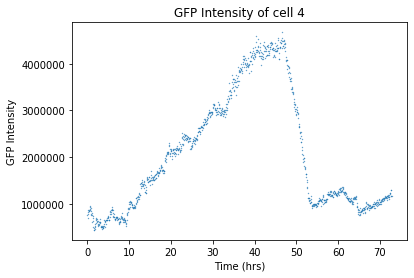

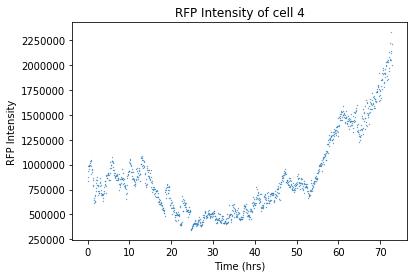

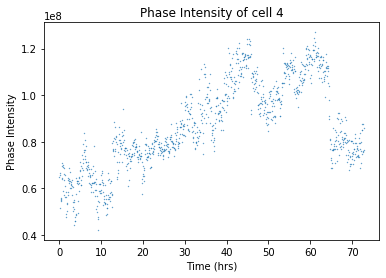

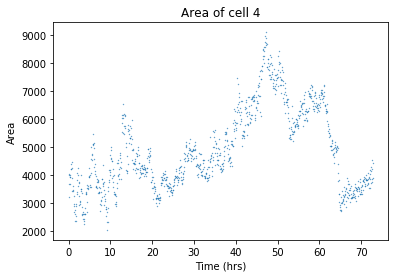

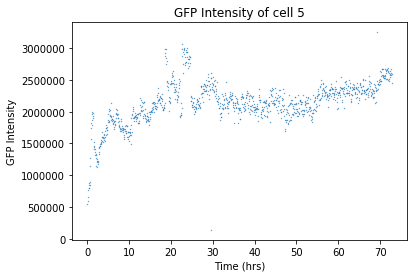

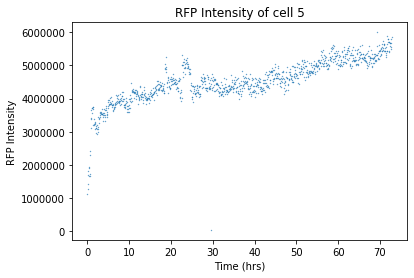

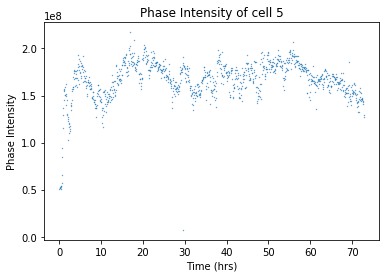

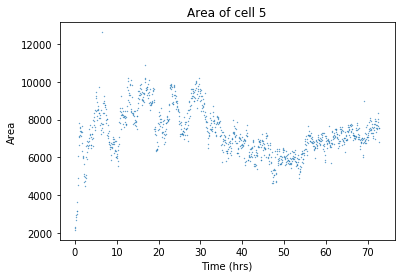

In [6]:
### Raw data plots 
for cell in cell_ids:
    cell_id = "cell" + cell
    stat_location = os.path.join(cell_id, "stats.csv")

    df = pd.read_csv(os.path.join(root_path, stat_location))

    x = df.index
    x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins

    y_variables = df.columns[0:4] #this calls just the first four variables 
    for y in y_variables:
        intensity = df[y]            
        plt.scatter(x_time,[intensity], s= 0.1)
        plt.ylabel(y)
        plt.xlabel('Time (hrs)')
        title = y + ' of cell ' + cell
        plt.title(title)
        plt.show()


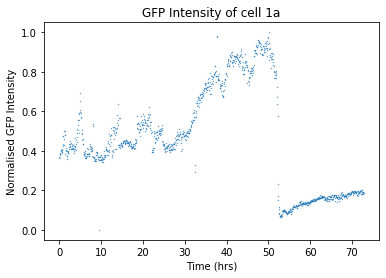

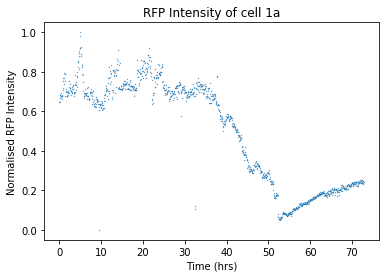

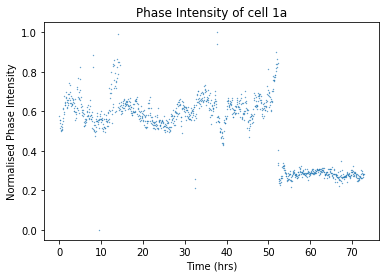

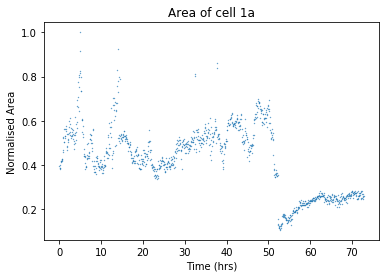

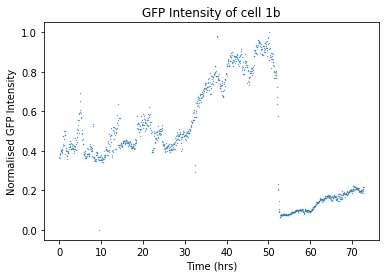

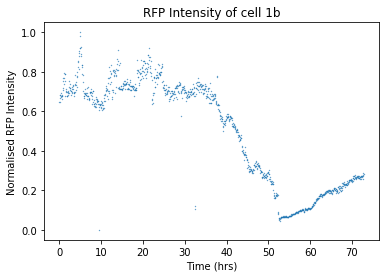

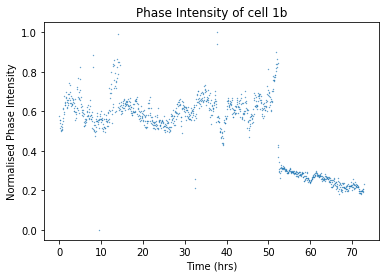

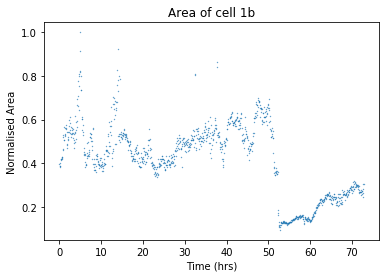

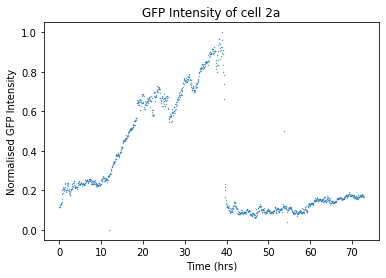

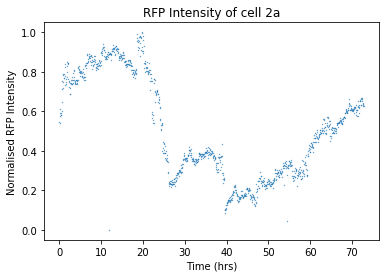

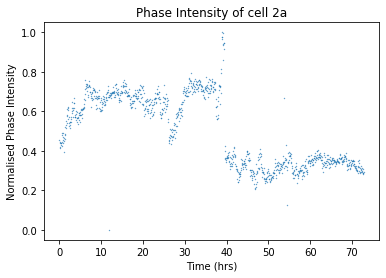

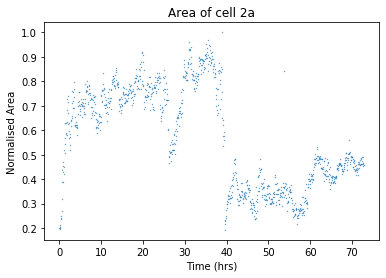

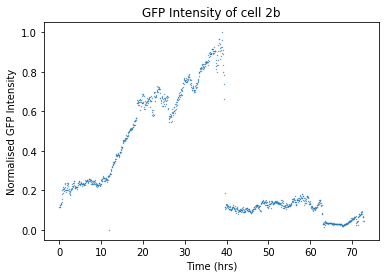

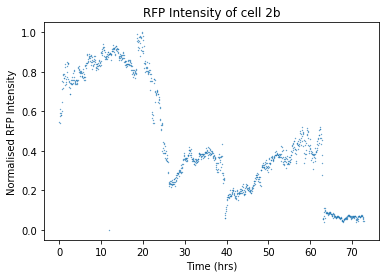

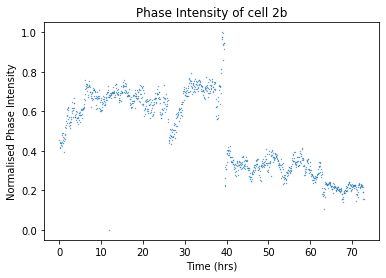

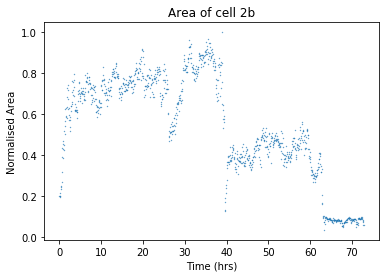

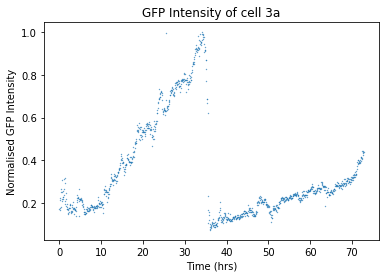

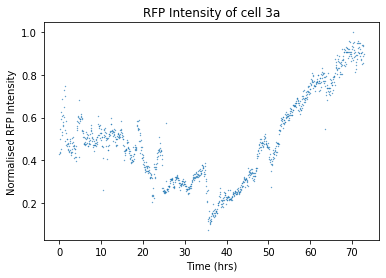

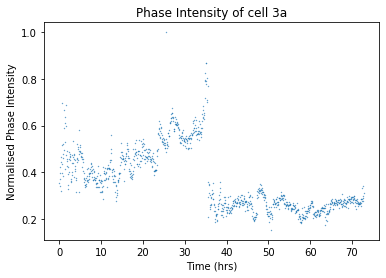

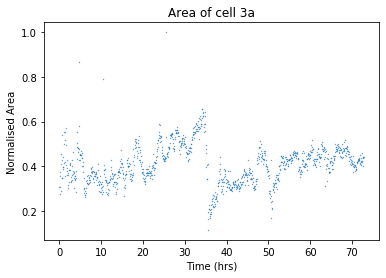

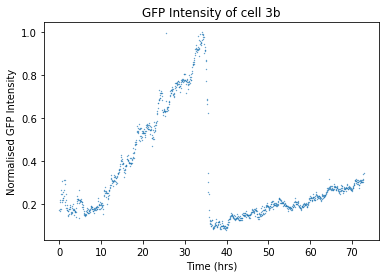

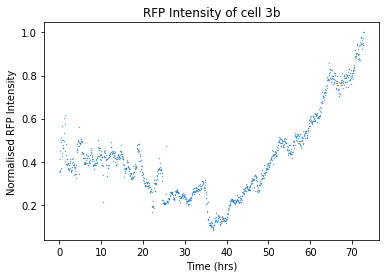

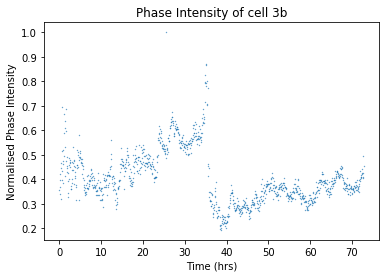

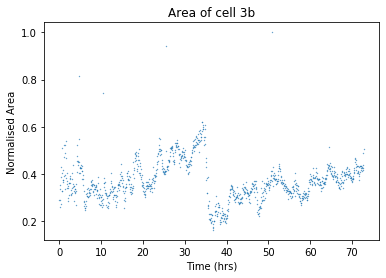

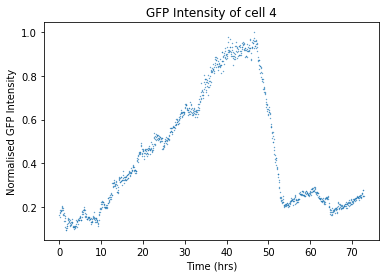

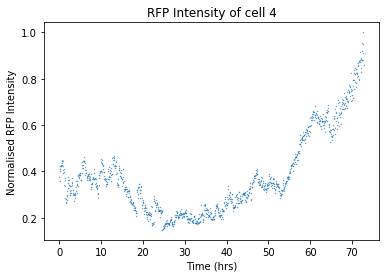

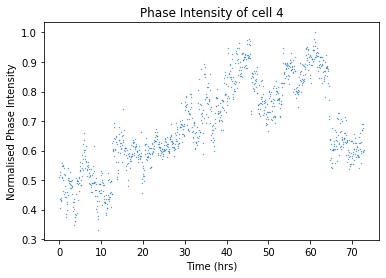

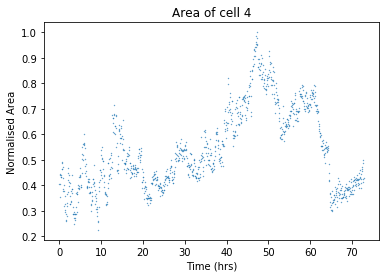

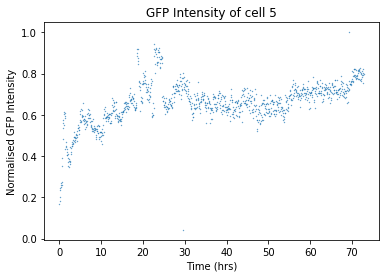

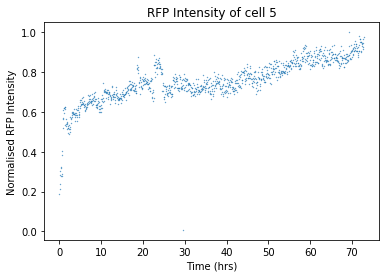

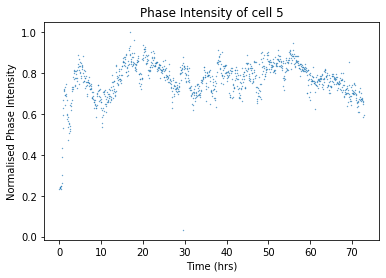

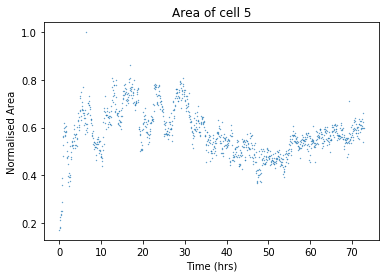

In [7]:
### Normalised data plots

for cell in cell_ids:
    cell_id = "cell" + cell
    stat_location = os.path.join(cell_id, "stats.csv")

    df = pd.read_csv(os.path.join(root_path, stat_location))

    x = df.index
    x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins

    y_variables = df.columns[0:4] #this calls just the first four variables 
    for y in y_variables:
        #intensity = df[y] 
        norm_intensity = normalisation(df[y])      
        plt.scatter(x_time,[norm_intensity], s= 0.1)
        ylabel = "Normalised " + y
        plt.ylabel(ylabel)
        plt.xlabel('Time (hrs)')
        title = y + ' of cell ' + cell
        plt.title(title)
        plt.show()

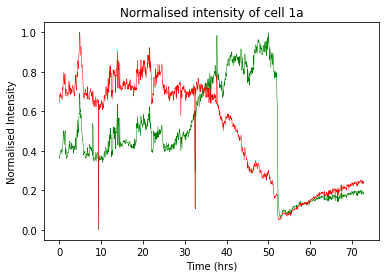

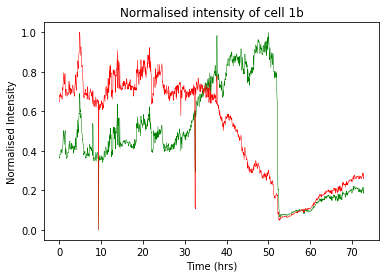

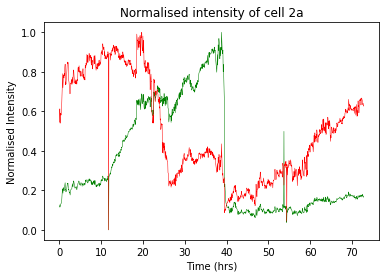

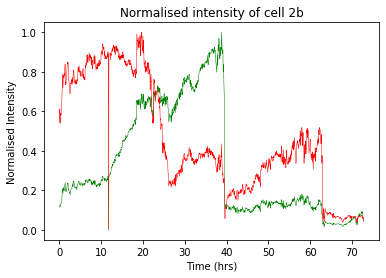

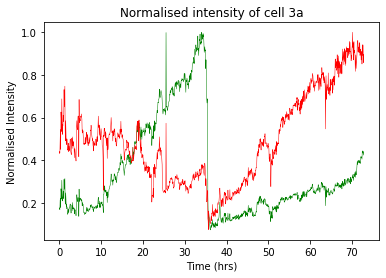

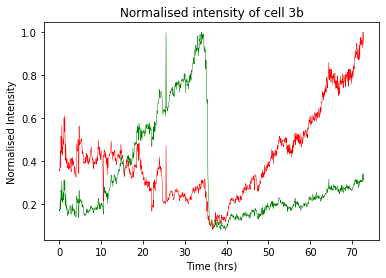

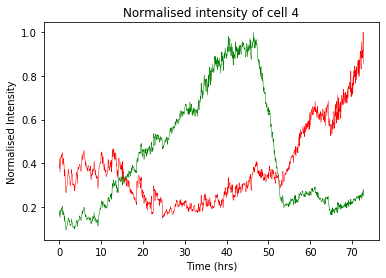

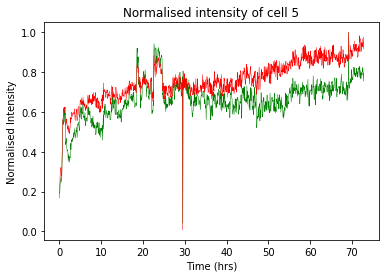

In [16]:
### Overlaid normalised plots 

for cell in cell_ids:
    cell_id = "cell" + cell
    stat_location = os.path.join(cell_id, "stats.csv")

    df = pd.read_csv(os.path.join(root_path, stat_location))
    norm_df = pd.DataFrame([])

    x = df.index
    x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins
    
    # collect different intensities to plot
    for y in y_variables:
            #intensity = df[y] 
            y_name = 'Normalised ' + y
            norm_intensity = normalisation(df[y]) 
            norm_df[y_name] = norm_intensity   
    
    #plotting intensities on same plot
    for column in norm_df.columns[0:2]: #index in df.columns indicate variables to plot
        colour = colour_picker(column)
        plt.plot(x_time, norm_df[column], linewidth=0.5, color=colour)
    plt.ylabel("Normalised Intensity")
    plt.xlabel('Time (hrs)')
    title = "Normalised intensity of cell " + cell
    #title = norm_df.columns[0]+", "+ norm_df.columns[1]+ ", "+ norm_df.columns[2]+" of cell " + cell
    plt.title(title)
    plt.show()       

Index(['Normalised GFP Intensity', 'Normalised RFP Intensity',
       'Normalised Phase Intensity'],
      dtype='object')
Normalised GFP Intensity


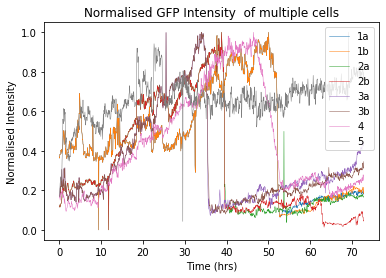

Normalised RFP Intensity


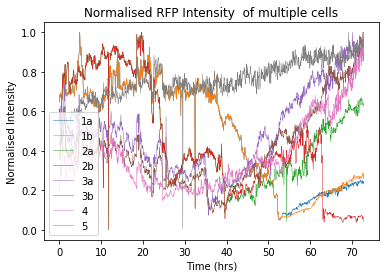

Normalised Phase Intensity


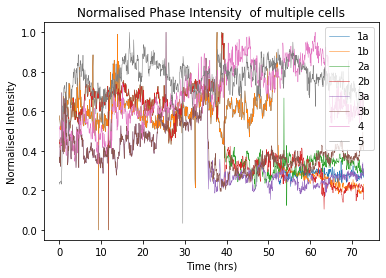

In [32]:
# overlaid multicell plots, alignment needed
norm_df = pd.DataFrame([])
norm_df_list = []

for cell in cell_ids:
    cell_id = "cell" + cell
    stat_location = os.path.join(cell_id, "stats.csv")

    df = pd.read_csv(os.path.join(root_path, stat_location))

    x = df.index
    x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins
    
    # collect different intensities to plot
    for y in y_variables:
            #intensity = df[y] 
            y_name = 'Normalised ' + y
            norm_intensity = normalisation(df[y]) 
            norm_df[y_name] = norm_intensity
    
    stat_location = os.path.join(cell_id, "normalised_stats.csv")
    norm_stat_file = os.path.join(root_path, stat_location)
    norm_df.to_csv(norm_stat_file, index=False)
    norm_df_list.append(norm_stat_file)
    
#need to edit these dataframes and and align them so that norm_df[i].min is all aligned 
for i, cell in enumerate(cell_ids):
    norm_df = pd.read_csv(cell_info[i].path)
    #now shift index of df so that the three column variables 
    norm_df
    shift = #amount to shift the df by
    norm_df.shift(periods=shift)

    
# for each channel
for column in norm_df.columns[0:3]:
    #for each cell
    for i, cell in enumerate(cell_ids):
        #print(cell)
        norm_df = pd.read_csv(cell_info[i].path)
        #colour = colour_picker(column)
        plt.plot(x_time, norm_df[column], linewidth=0.5, label = cell)#, color=colour)

    plt.ylabel("Normalised Intensity")
    plt.xlabel('Time (hrs)')
    title = column+ "  of multiple cells"
    plt.title(title)
    plt.legend()
    plt.show()   

In [57]:
#for i, cell in enumerate(cell_ids):
i=1
norm_df = pd.read_csv(cell_info[i].path)

differences_df = norm_df.diff(periods=30)
differences_df.idxmax(axis=0)

#differences = norm_df.diff(periods = 30, axis = 0)
#print(differences["Normalised GFP Intensity"].idxmax(axis=0))
#print(norm_df)
#max_point = norm_df["Normalised GFP Intensity"].idxmax(axis=0)) #currently using the max point of the 
#shift = 0 #amount to shift the df by
#norm_df.shift(periods=shift)


Normalised GFP Intensity      518
Normalised RFP Intensity      171
Normalised Phase Intensity    171
Normalised Area                73
dtype: int64